In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch

random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

def get_kidney_dataframe():

    DATA_PATH = "../../../sail-safe-functions-test/sail_safe_functions_test/data_sail_safe_functions"
    path_file_csv = os.path.join(DATA_PATH, "data_csv_kidney_clean", "kidney_disease_clean.csv")
    df =  pd.read_csv(path_file_csv)
    df = pd.get_dummies(data=df)
    # df = pd.concat([df,df], axis=0)
    # df = pd.concat([df,df], axis=0)
    # df = pd.concat([df,df], axis=0)

    return df

def get_test_federation_split(df):

    train = df.sample(frac=0.8, random_state=0)
    test = df.drop(train.index)
    
    shuffled = train.sample(frac=1)
    result = np.array_split(shuffled, 5)  

    return result, test

dataframe = get_kidney_dataframe()

In [30]:
X_col = ['age', 'bp', 'sg', 'al']
Y_col = ['classification_ckd']
in_layer = len(X_col)
out_layer = len(Y_col)
epochs = 5000
learn_rate = 0.001

In [31]:
from helper_libs.shared.models.LogisticRegression import LogisticRegression


model = LogisticRegression(in_layer, out_layer)

criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

In [32]:
from torch.autograd import Variable
from helper_libs.scn_side.machine_learning.ModelUtility import ModelUtility

for epoch in range(epochs):

    inputs = Variable(ModelUtility.dataframe_to_tensor(dataframe[X_col]))
    labels = Variable(ModelUtility.dataframe_to_tensor(dataframe[Y_col]))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)

    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 2.7572035789489746
epoch 1, loss 1.900136113166809
epoch 2, loss 1.7763234376907349
epoch 3, loss 1.7393683195114136
epoch 4, loss 1.7131531238555908
epoch 5, loss 1.6885393857955933
epoch 6, loss 1.6642556190490723
epoch 7, loss 1.6401046514511108
epoch 8, loss 1.6160597801208496
epoch 9, loss 1.5921188592910767
epoch 10, loss 1.5682913064956665
epoch 11, loss 1.5445756912231445
epoch 12, loss 1.5209819078445435
epoch 13, loss 1.4975067377090454
epoch 14, loss 1.474169135093689
epoch 15, loss 1.4509551525115967
epoch 16, loss 1.427884817123413
epoch 17, loss 1.4049590826034546
epoch 18, loss 1.3821814060211182
epoch 19, loss 1.3595613241195679
epoch 20, loss 1.3371036052703857
epoch 21, loss 1.3148131370544434
epoch 22, loss 1.292700171470642
epoch 23, loss 1.2707687616348267
epoch 24, loss 1.2490284442901611
epoch 25, loss 1.2274852991104126
epoch 26, loss 1.2061476707458496
epoch 27, loss 1.185024380683899
epoch 28, loss 1.16412353515625
epoch 29, loss 1.14345395565032

/tmp/ipykernel_10193/311939865.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)


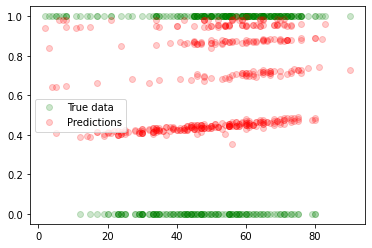

In [33]:
import matplotlib.pyplot as plt

def print_graph(predicted, x_train, y_train):


    # predictions = []
    # for prediction in predicted:
    #         predictions.append(prediction.argmax())

    # predictions = []
    # for prediction in predicted: 
    #     if prediction > 0.5:
    #         predictions.append(1)
    #     else:
    #         predictions.append(0)
    predictions = predicted
    labels = y_train


    column_a = []
    for x in x_train:
        column_a.append(x[0])

    plt.plot(column_a, labels, 'go', label='True data', alpha=0.2)
    plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)
    plt.legend(loc='best')
    plt.show()

X_test = torch.Tensor(dataframe[X_col].values).float()
Y_test = torch.Tensor(dataframe[Y_col].values).float()

predicted = model(X_test).detach().numpy()
print_graph(predicted, X_test, Y_test)

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

def score_model(predicted, Y_test):
    predictions = predicted

    labels = Y_test

    precision = precision_score(predictions, labels, average="weighted")
    recall = recall_score(predictions, labels, average="weighted")
    f1 = f1_score(predictions, labels, average="weighted")

    return precision, recall, f1

#Binarize continuous classifications
predictions = []
for prediction in predicted: 
    if prediction > 0.6:
        predictions.append(1)
    else:
        predictions.append(0)

print(score_model(predictions, Y_test))

(0.89416, 0.865, 0.8628760355704188)
